In [1]:
## Loads image and generates it heatmap for the activation of last bock in the model
def cam(img_path):
    from keras.applications.vgg16 import VGG16
    import matplotlib.image as mpimg
    from keras import backend as K
    import matplotlib.pyplot as plt
    %matplotlib inline
    K.clear_session()
    from keras.applications.vgg16 import decode_predictions
    model = VGG16(weights='imagenet')
    img=mpimg.imread(img_path)
    plt.imshow(img)
    from keras.preprocessing import image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    from keras.applications.vgg16 import preprocess_input
    x = preprocess_input(x)
    preds = model.predict(x)
    predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    import cv2
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = 'out.jpg'
    cv2.imwrite(output, superimposed_img)
    img=mpimg.imread(output)
    plt.imshow(img)
    plt.axis('off')
    plt.title(predictions.loc[0,'category'].upper())
    return None

In [2]:
## Loads the given model
def load_model(name):
    json_file = open('./Models/'+name+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("./Models/"+name+".h5")
    return loaded_model

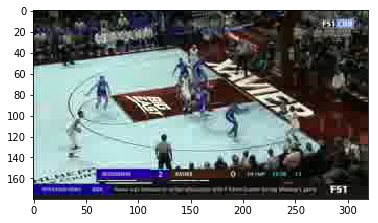

In [16]:
#cam('./data/')
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image
data=pd.read_csv("./data/three_point_training_data1.csv",header=None)
#img=np.expand_dims(np.transpose(image.img_to_array(image.load_img("./data/"+data.iloc[0,0],target_size=(224,224))),(1,0,2)),axis=0)
img="./data/"+data.iloc[12,0]
im = cv2.imread(img)
plt.imshow(im)

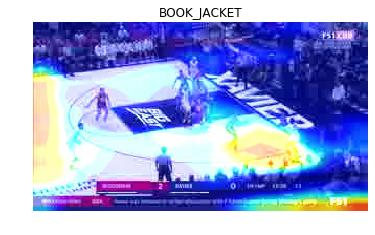

In [17]:
cam(img)

In [ ]:
!aws s3 cp --recursive --quiet s3://asu-fox-hackathon-training/10031 10031